<a href="https://colab.research.google.com/github/DanAkarca/modular_experts/blob/main/experiment_1b.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Very early heterogeneous MoE experimenet w/ heterogeneous time signals

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

class ExpertLayer(nn.Module):
    def __init__(self, input_size, hidden_size, num_experts):
        super().__init__()
        self.num_experts = num_experts

        # Each expert is a 2-layer network
        self.experts = nn.ModuleList([
            nn.Sequential(
                nn.Linear(input_size, hidden_size),
                nn.ReLU(),
                nn.Linear(hidden_size, 1)
            ) for _ in range(num_experts)
        ])

        # Router network
        self.router = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, num_experts)
        )

    def forward(self, x):
        # Get routing weights
        router_weights = F.softmax(self.router(x), dim=-1)

        # Get predictions from each expert
        expert_outputs = torch.stack([expert(x) for expert in self.experts], dim=1)

        # Combine expert outputs using routing weights
        output = torch.sum(router_weights.unsqueeze(-1) * expert_outputs, dim=1)
        return output, router_weights

class MoEForecaster(nn.Module):
    def __init__(self, input_size, hidden_size, num_experts):
        super().__init__()
        self.expert_layer = ExpertLayer(input_size, hidden_size, num_experts)

    def forward(self, x):
        output, routing_weights = self.expert_layer(x)
        return output, routing_weights

class DenseForecaster(nn.Module):
    def __init__(self, input_size, hidden_size):
        super().__init__()
        self.network = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, 1)
        )

    def forward(self, x):
        return self.network(x), None

def generate_synthetic_data(n_samples=1000, seq_length=50):
    # Generate three types of time series:
    # 1. Sine waves with different frequencies
    # 2. Linear trends with noise
    # 3. Step functions with random jumps

    X = []
    y = []
    types = []

    for _ in range(n_samples):
        type_idx = np.random.randint(0, 3)
        t = np.linspace(0, 10, seq_length)

        if type_idx == 0:  # Sine wave
            freq = np.random.uniform(0.5, 2.0)
            series = np.sin(2 * np.pi * freq * t)
            series += np.random.normal(0, 0.1, seq_length)

        elif type_idx == 1:  # Linear trend
            slope = np.random.uniform(-1, 1)
            series = slope * t
            series += np.random.normal(0, 0.1, seq_length)

        else:  # Step function
            series = np.zeros(seq_length)
            change_points = np.random.choice(seq_length, 3, replace=False)
            for point in change_points:
                series[point:] += np.random.uniform(-1, 1)
            series += np.random.normal(0, 0.1, seq_length)

        X.append(series[:-1])
        y.append(series[-1])
        types.append(type_idx)

    return torch.FloatTensor(X), torch.FloatTensor(y).reshape(-1, 1), types

def train_model(model, X_train, y_train, epochs=100, lr=0.001):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    losses = []

    for epoch in range(epochs):
        optimizer.zero_grad()

        # Forward pass
        predictions, routing_weights = model(X_train)
        loss = F.mse_loss(predictions, y_train)

        # Backward pass
        loss.backward()
        optimizer.step()

        losses.append(loss.item())

        if (epoch + 1) % 10 == 0:
            print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')

    return losses

In [4]:
# Generate data
X, y, types = generate_synthetic_data()

# Split into train/test
train_size = int(0.8 * len(X))
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]
types_train, types_test = types[:train_size], types[train_size:]

# Initialize models
moe_model = MoEForecaster(input_size=49, hidden_size=64, num_experts=4)
dense_model = DenseForecaster(input_size=49, hidden_size=64)

# Train both models
print("Training MoE model...")
moe_losses = train_model(moe_model, X_train, y_train)

print("\nTraining Dense model...")
dense_losses = train_model(dense_model, X_train, y_train)

# Evaluate
moe_model.eval()
dense_model.eval()

with torch.no_grad():
    moe_preds, routing_weights = moe_model(X_test)
    dense_preds, _ = dense_model(X_test)

    moe_mse = F.mse_loss(moe_preds, y_test).item()
    dense_mse = F.mse_loss(dense_preds, y_test).item()

    print(f"\nTest MSE:")
    print(f"MoE Model: {moe_mse:.4f}")
    print(f"Dense Model: {dense_mse:.4f}")

<ipython-input-3-f659bc298ba9>:96: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  return torch.FloatTensor(X), torch.FloatTensor(y).reshape(-1, 1), types


Training MoE model...
Epoch [10/100], Loss: 1.3261
Epoch [20/100], Loss: 0.5355
Epoch [30/100], Loss: 0.3635
Epoch [40/100], Loss: 0.2890
Epoch [50/100], Loss: 0.2748
Epoch [60/100], Loss: 0.2473
Epoch [70/100], Loss: 0.2413
Epoch [80/100], Loss: 0.2310
Epoch [90/100], Loss: 0.2234
Epoch [100/100], Loss: 0.2159

Training Dense model...
Epoch [10/100], Loss: 5.9854
Epoch [20/100], Loss: 1.4086
Epoch [30/100], Loss: 0.4383
Epoch [40/100], Loss: 0.3121
Epoch [50/100], Loss: 0.3199
Epoch [60/100], Loss: 0.2520
Epoch [70/100], Loss: 0.2429
Epoch [80/100], Loss: 0.2333
Epoch [90/100], Loss: 0.2216
Epoch [100/100], Loss: 0.2128

Test MSE:
MoE Model: 0.1997
Dense Model: 0.1955


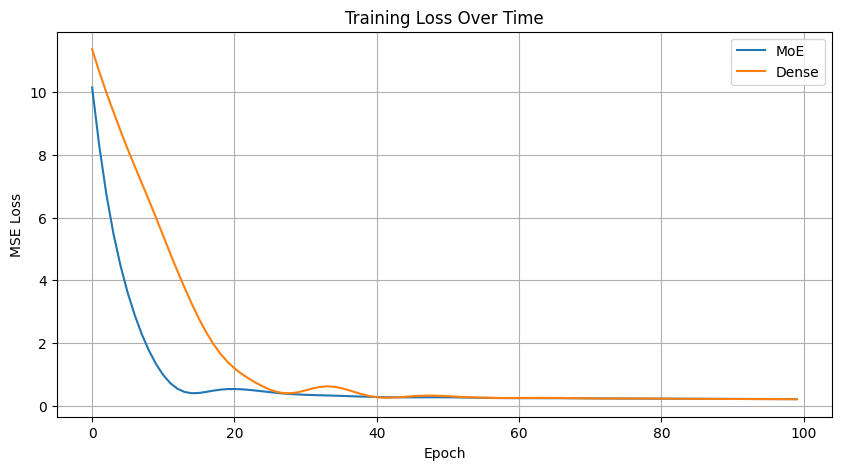

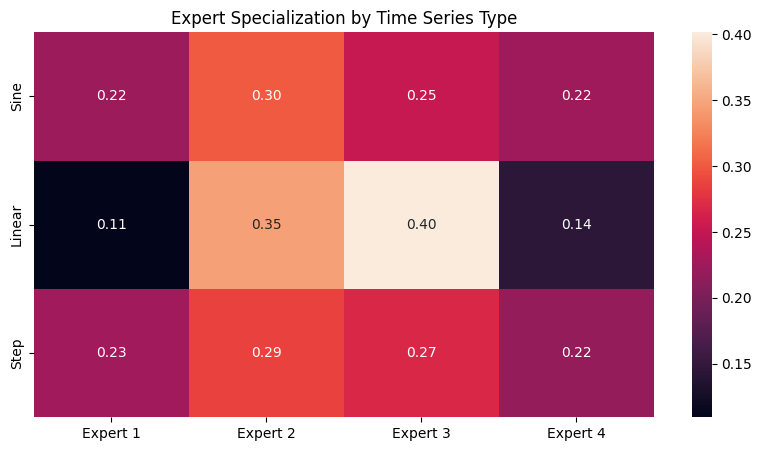


R² Scores:
MoE Model: 0.9851
Dense Model: 0.9854


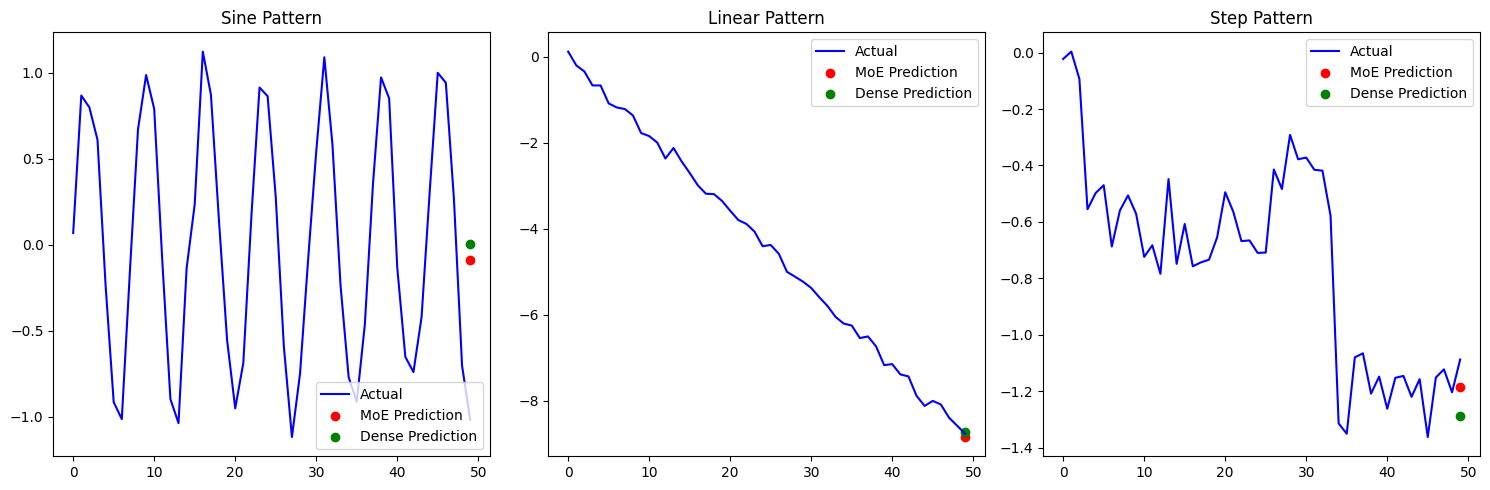

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score

# Plot training losses
plt.figure(figsize=(10, 5))
plt.plot(moe_losses, label='MoE')
plt.plot(dense_losses, label='Dense')
plt.title('Training Loss Over Time')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.legend()
plt.grid(True)
plt.show()

# Analyze expert specialization
with torch.no_grad():
    _, routing_weights = moe_model(X_test)
    routing_weights = routing_weights.numpy()

    # For each type, get average routing weights
    type_routing = {0: [], 1: [], 2: []}
    for i, type_idx in enumerate(types_test):
        type_routing[type_idx].append(routing_weights[i])

    # Average routing weights per type
    avg_routing = np.array([np.mean(type_routing[i], axis=0) for i in range(3)])

# Visualize expert specialization
plt.figure(figsize=(10, 5))
sns.heatmap(avg_routing, annot=True, fmt='.2f',
            xticklabels=[f'Expert {i+1}' for i in range(4)],
            yticklabels=['Sine', 'Linear', 'Step'])
plt.title('Expert Specialization by Time Series Type')
plt.show()

# Calculate prediction accuracy
def get_predictions(model, X):
    with torch.no_grad():
        preds, _ = model(X)
        return preds.numpy()

# Get predictions
moe_preds = get_predictions(moe_model, X_test)
dense_preds = get_predictions(dense_model, X_test)

# Calculate R² score for both models
from sklearn.metrics import r2_score

moe_r2 = r2_score(y_test, moe_preds)
dense_r2 = r2_score(y_test, dense_preds)

print(f"\nR² Scores:")
print(f"MoE Model: {moe_r2:.4f}")
print(f"Dense Model: {dense_r2:.4f}")

# Plot example predictions
plt.figure(figsize=(15, 5))
for i, type_name in enumerate(['Sine', 'Linear', 'Step']):
    plt.subplot(1, 3, i+1)
    # Find first example of this type in test set
    idx = types_test.index(i)

    # Plot full sequence
    plt.plot(range(50), torch.cat([X_test[idx], y_test[idx]]),
             label='Actual', color='blue')

    # Plot predictions
    plt.scatter(49, moe_preds[idx], color='red', label='MoE Prediction')
    plt.scatter(49, dense_preds[idx], color='green', label='Dense Prediction')

    plt.title(f'{type_name} Pattern')
    plt.legend()

plt.tight_layout()
plt.show()